# Import

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from os import name
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets

from triqlet.quantum.models import QuantumSamplerModel
from triqlet.quantum.layers import PoolingLayer, RealAmplitudeLayer, SwapTestLayer, EncoderLayer, QuantumSequential
from triqlet.triplet.datasets import TripletImageDataset


# Encoding e Utility

Color classes for colorful printing

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Training device selection

In [4]:
device = torch.device("cpu")

if not torch.cuda.is_available():
    print(f"{color.GREEN}CUDA{color.END} NOT Available")
else:
    print(f"{color.GREEN}CUDA{color.END} Available")
    device = torch.device("cuda")


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ and/or you do not have an MPS-enabled device on this machine.")
else:
    print(f"{color.BLUE}MPS{color.END} Available")
    device = torch.device("mps")

print(f"Using {color.BOLD}{color.PURPLE}{str(device).upper()}{color.END} Acceleration")

CUDA Available
MPS not available because the current PyTorch install was not built with MPS enabled.
Using CUDA Acceleration


Helper functions for clustring evaluation metrics

In [6]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# MNIST / FashionMNIST Images Dataset

In [5]:
NUM_CLASSES = 10
SAMPLER_PER_CLASS = 30
INITIAL_TRAINING_SAMPLES = NUM_CLASSES * SAMPLER_PER_CLASS
LOAD_FASHION = False
RANDOM_STATE = 42

Ensuring test and training set have a balanced number of classes

In [7]:
MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])

if LOAD_FASHION:
    MNIST_dataset_train = datasets.FashionMNIST(root="../../data/dataset/FashionMNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.FashionMNIST(root="../../data/dataset/FashionMNIST", train=False, download=True, transform=MNIST_base_transform)
else:
    MNIST_dataset_train = datasets.MNIST(root="../../data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.MNIST(root="../../data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)


index01 = MNIST_dataset_train.targets < NUM_CLASSES
MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

index01_test = MNIST_dataset_test.targets < NUM_CLASSES
MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]



print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=RANDOM_STATE,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")

FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (300, 28, 28)
Total training samples : 300

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



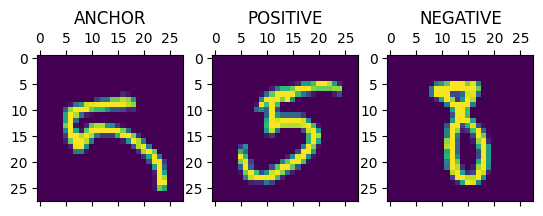

In [15]:
t = TripletImageDataset(X, y, NUM_CLASSES, transforms.ToTensor())

anchor, pos, neg = t[0]
fig, axs = plt.subplots(1,3)

axs[0].set_title("ANCHOR")
axs[0].matshow(anchor.squeeze(0))

axs[1].set_title("POSITIVE")
axs[1].matshow(pos.squeeze(0))

axs[2].set_title("NEGATIVE")
axs[2].matshow(neg.squeeze(0))

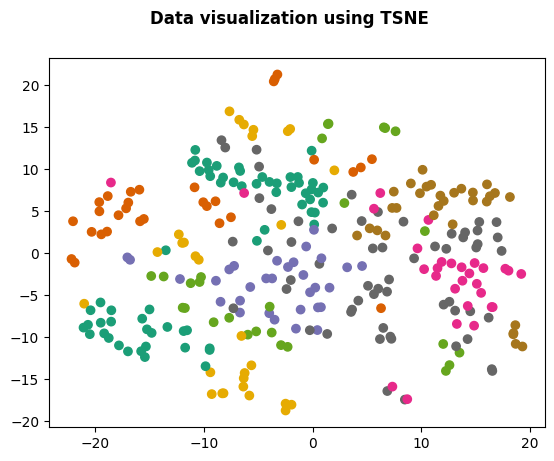

In [16]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# Quantum Neural Network Circuits using TriQlet

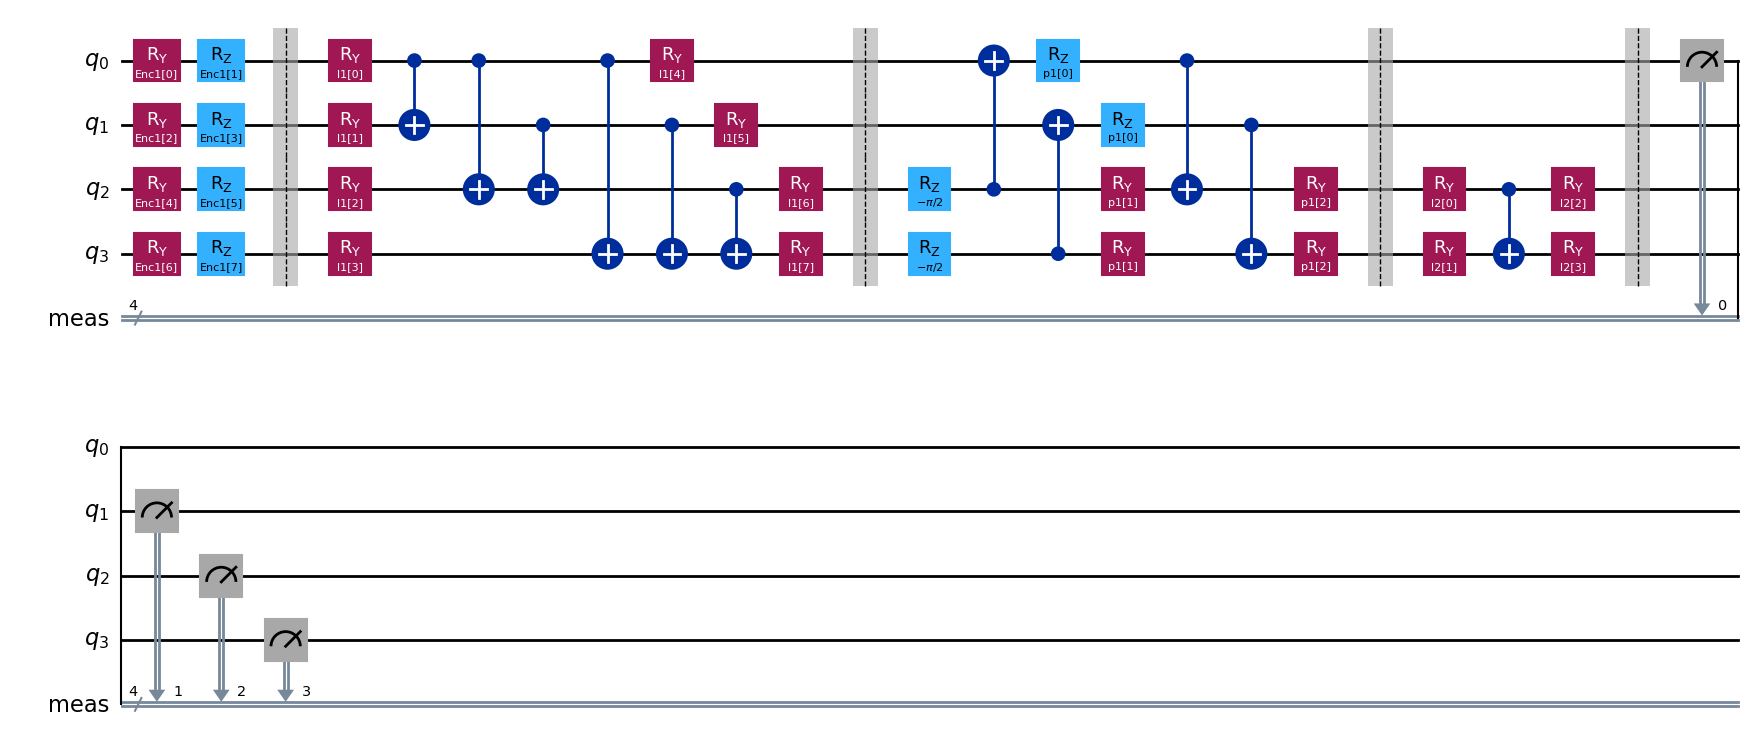

In [11]:
YZ_CNN_FullMeas = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True),
        PoolingLayer(4, [0,1], [2,3], "p1", "Pool", True),
        RealAmplitudeLayer(4, [2,3], "full", 1, "l2", "L2", True)
    ),
    
    shots=1000,
    measurement=[0,1,2,3]

)

YZ_CNN_FullMeas.draw(decompose=True)

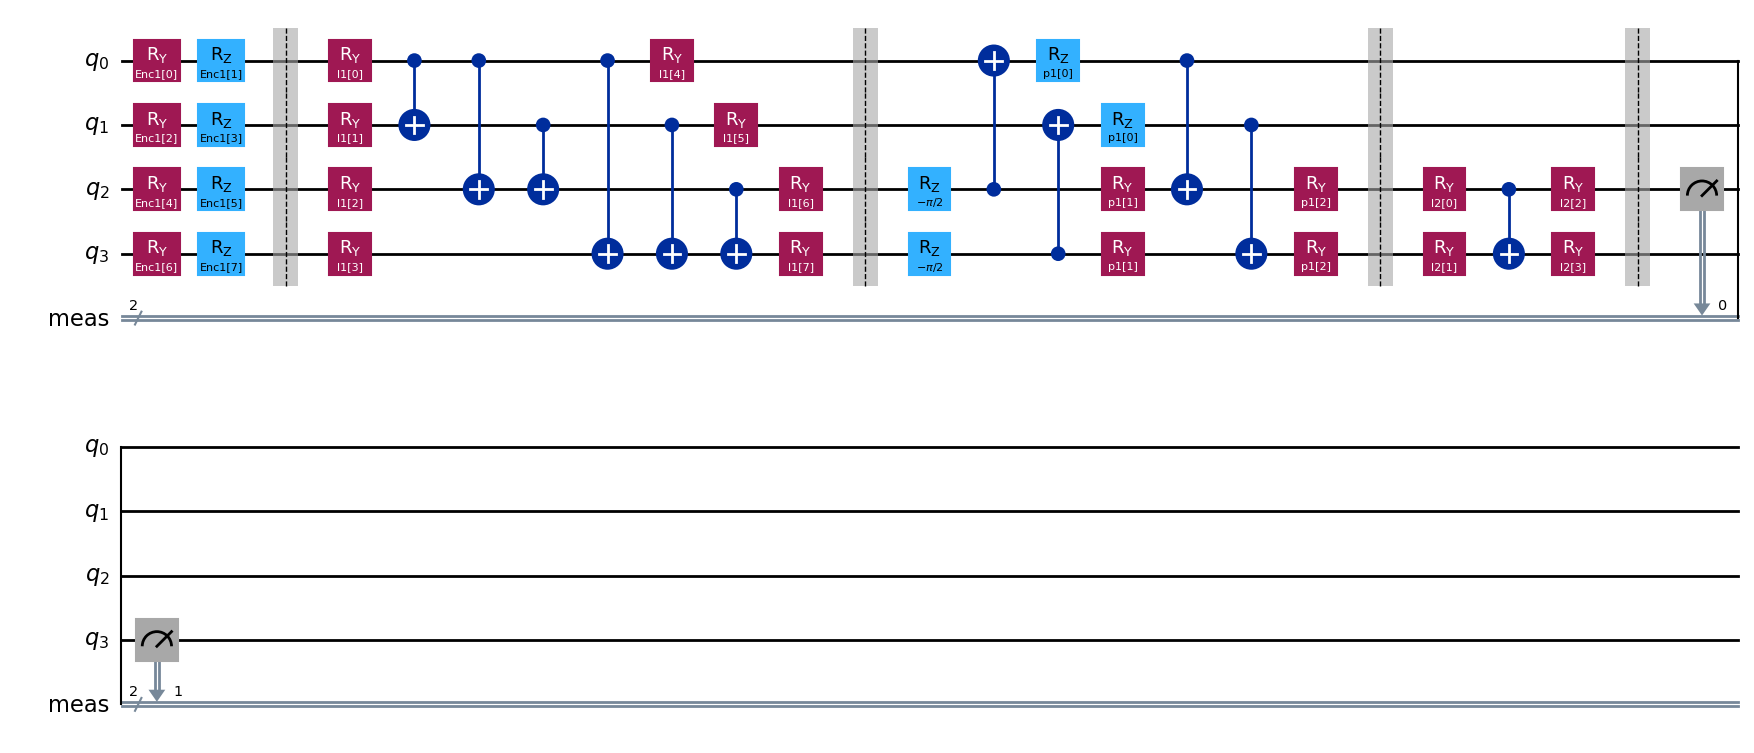

In [12]:
YZ_CNN_PoolMeas = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True),
        PoolingLayer(4, [0,1], [2,3], "p1", "Pool", True),
        RealAmplitudeLayer(4, [2,3], "full", 1, "l2", "L2", True)
    ),
    
    shots=1000,
    measurement=[2,3]

)

YZ_CNN_PoolMeas.draw(decompose=True)

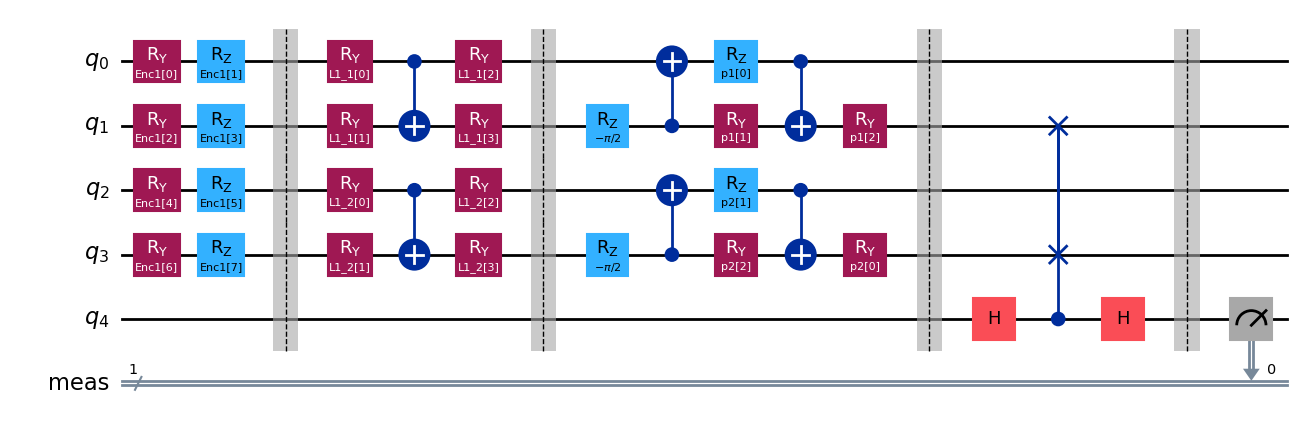

In [13]:
YZ_Pool_Swap = QuantumSamplerModel(
    circ_qubits = 5,

    encoder =EncoderLayer(
        circ_qubits=5,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(5, [0,1], "full", 1, "L1_1", "L1_1", False),
        RealAmplitudeLayer(5, [2,3], "full", 1, "L1_2", "L1_2", True),
        PoolingLayer(5, [0], [1], "p1", "P1", False),
        PoolingLayer(5, [2], [3], "p2", "P2", True),
        SwapTestLayer(5, [1], [3], 4, "Swap", True)
    ),
    
    shots=1000,
    measurement=[4]

)

YZ_Pool_Swap.draw(decompose=True)

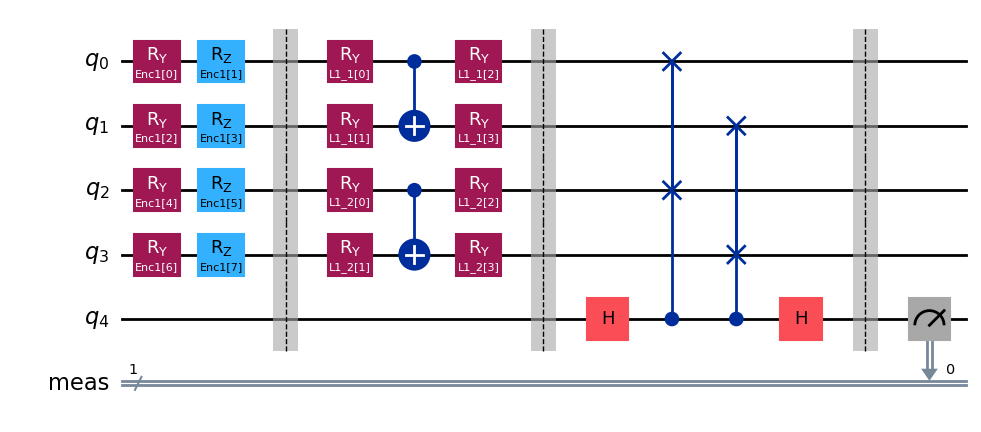

In [14]:
YZ_Swap = QuantumSamplerModel(
    circ_qubits = 5,

    encoder =EncoderLayer(
        circ_qubits=5,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(5, [0,1], "full", 1, "L1_1", "L1_1", False),
        RealAmplitudeLayer(5, [2,3], "full", 1, "L1_2", "L1_2", True),
        SwapTestLayer(5, [0,1], [2,3], 4, "Swap", True)
    ),
    
    shots=1000,
    measurement=[4]

)

YZ_Swap.draw(decompose=True)

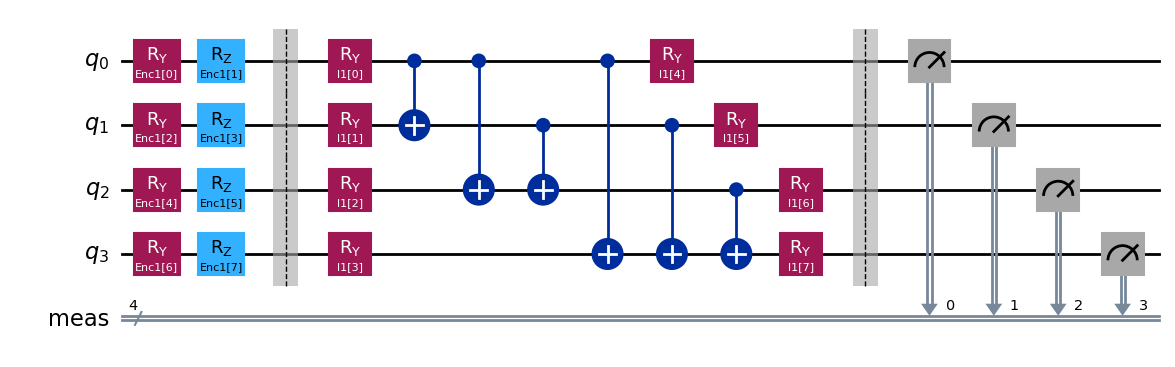

In [15]:
YZ_OnlyReal = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True)
    ),
    
    shots=1000,
    measurement=[0,1,2,3]

)

YZ_OnlyReal.draw(decompose=True)

# Classical SiameseNetworks using TriQlet

In [16]:
class RotationScaler(nn.Module):
    def __init__(self, scale=1):
        super(RotationScaler, self).__init__()

        self.sig = torch.nn.Sigmoid()
        self.scale = scale

    def forward(self, x):
        x = self.sig(x)
        x = x * self.scale
        
        return x
    

class EmbeddingModel(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingModel, self).__init__()

        self.embedding_size = embedding_size
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=embedding_size)
        )

        self.scaler = RotationScaler(scale=2*torch.pi)

    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)
        x = self.reduction(x)
        
        x = self.scaler(x)

        return x



summary(EmbeddingModel(4).to(device if torch.cuda.is_available() else "cpu"), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 4]             484
          Sigmoid-13                    [-1, 4]               0
   RotationScaler-14                   

In [17]:
class QuantumEmbedder(nn.Module):
    def __init__(self, qnn_net):
        super(QuantumEmbedder, self).__init__()
        self.ql = TorchConnector(qnn_net)

        self.embed_adjuster = nn.Sequential(
            nn.Linear(16,16)
        )
    
    
    def forward(self, anchor):
        return self.embed_adjuster(self.ql(anchor))


QuantumEmbedder(YZ_RL_FullMeas()()).to(device)(torch.rand((3,8)).to(device))

NameError: name 'YZ_RL_FullMeas' is not defined

In [ ]:
class QuantumDistance(nn.Module):
    def __init__(self, qnn_net):
        super(QuantumDistance, self).__init__()
        self.ql = TorchConnector(qnn_net)
    
    
    def forward(self, anchor, sample):
        return (self.ql(torch.hstack((anchor, sample)))[:, :1] - 0.5 ) / 0.5


QuantumDistance(YZ_Swap()()).to(device)(torch.rand((3,4)).to(device), torch.rand((3,4)).to(device))


tensor([[0.6900],
        [0.6848],
        [0.7137]], device='mps:0', grad_fn=<DivBackward0>)

In [ ]:
class ClassicalDistance(nn.Module):
    def __init__(self):
        super(ClassicalDistance, self).__init__()
    
    def forward(self, anchor, sample):
        return torch.norm(anchor - sample, dim=1, keepdim=True)

ClassicalDistance().to(device)(torch.rand((3,4)).to(device), torch.rand((3,4)).to(device))

tensor([[0.7053],
        [0.6618],
        [0.5552]], device='mps:0')

In [ ]:
class ClassicalLearnedDistance(nn.Module):
    def __init__(self, embedding_size):
        super(ClassicalLearnedDistance, self).__init__()


        self.embedding_size = embedding_size

        self.learner = nn.Sequential(
            nn.Linear(embedding_size * 2, 1)
        )

    def forward(self, anchor, sample):
        return self.learner(torch.hstack((anchor, sample)))

ClassicalLearnedDistance(2).to(device)(torch.rand((3,2)).to(device), torch.rand((3,2)).to(device))

tensor([[-0.7187],
        [-0.1685],
        [-0.5171]], device='mps:0', grad_fn=<LinearBackward0>)

In [ ]:
class TripletQuantumEmbedNet(nn.Module):
    def __init__(self, classical_embedding, quantum_embedding, distance):
        super(TripletQuantumEmbedNet, self).__init__()

        self.embedding = classical_embedding
        self.qembed = quantum_embedding
        self.distance = distance

    
    def forward(self, anchor, positive, negative):

        a = self.qembed(self.embedding(anchor))
        p = self.qembed(self.embedding(positive))
        n = self.qembed(self.embedding(negative))

        dp = self.distance(a, p)
        dn = self.distance(a, n)

        return dp, dn
    
print(f"{color.BOLD}Quantum {color.RED}Full Measurament RealAmplitudes {color.END}{color.BOLD}Model")
display(TripletQuantumEmbedNet(
    EmbeddingModel(8),
    QuantumEmbedder(YZ_RL_FullMeas()()),
    ClassicalDistance()
    )(torch.rand((2,1,28,28)), torch.rand((2,1,28,28)), torch.rand((2,1,28,28))))

Quantum Full Measurament RealAmplitudes Model


(tensor([[0.0007],
         [0.0006]], grad_fn=<LinalgVectorNormBackward0>),
 tensor([[0.0012],
         [0.0009]], grad_fn=<LinalgVectorNormBackward0>))

In [ ]:
class TripletDistanceNet(nn.Module):
    def __init__(self, embedding, distance):
        super(TripletDistanceNet, self).__init__()

        self.embedding = embedding
        self.distance = distance

    
    def forward(self, anchor, positive, negative):

        a = self.embedding(anchor)
        p = self.embedding(positive)
        n = self.embedding(negative)

        dp = self.distance(a, p)
        dn = self.distance(a, n)

        return dp, dn
    

print(f"{color.BOLD}Classical {color.RED}Euclidean Distance{color.END}{color.BOLD} Model")
display(TripletDistanceNet(
    EmbeddingModel(4), 
    ClassicalDistance()
    )(torch.rand((2,1,28,28)), torch.rand((2,1,28,28)), torch.rand((2,1,28,28))))

print(f"{color.BOLD}Classical {color.RED}Learned Distance{color.END}{color.BOLD} Model")
display(TripletDistanceNet(
    EmbeddingModel(4), 
    ClassicalLearnedDistance(4)
    )(torch.rand((2,1,28,28)), torch.rand((2,1,28,28)), torch.rand((2,1,28,28))))

print(f"{color.BOLD}Quantum {color.RED}Swap Test {color.END}{color.BOLD}Model")
display(TripletDistanceNet(
    EmbeddingModel(4), 
    QuantumDistance(YZ_Swap()())
    )(torch.rand((2,1,28,28)), torch.rand((2,1,28,28)), torch.rand((2,1,28,28))))




Classical Euclidean Distance Model


(tensor([[0.0155],
         [0.0069]], grad_fn=<LinalgVectorNormBackward0>),
 tensor([[0.0270],
         [0.0094]], grad_fn=<LinalgVectorNormBackward0>))

Classical Learned Distance Model


(tensor([[-0.2681],
         [-0.2637]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2666],
         [-0.2674]], grad_fn=<AddmmBackward0>))

Quantum Swap Test Model


(tensor([[0.7336],
         [0.7337]], grad_fn=<DivBackward0>),
 tensor([[0.7359],
         [0.7356]], grad_fn=<DivBackward0>))

In [ ]:
class CustomTripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(CustomTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, dist_pos, dist_neg):
        loss = torch.relu(dist_pos - dist_neg + self.margin)
        return loss.mean()

In [ ]:
distance_model = TripletQuantumEmbedNet(
    EmbeddingModel(8),
    QuantumEmbedder(YZ_RL_FullMeas()()),
    ClassicalDistance()
    )

training_dataloader = DataLoader(t, batch_size=10, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = CustomTripletLoss(margin=2)
epochs = 200

In [ ]:
LOAD_MODEL = True

distance_model = TripletQuantumEmbedNet(
    EmbeddingModel(8),
    QuantumEmbedder(YZ_RL_FullMeas()()),
    ClassicalDistance()
    )

if LOAD_MODEL:
    with open("boh100.pt", "rb") as f:
        distance_model.load_state_dict(torch.load(f, map_location=device))


training_dataloader = DataLoader(t, batch_size=10, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = CustomTripletLoss(margin=2)
epochs = 200

In [ ]:
%timeit distance_model(torch.rand((128,1,28,28)).to(device), torch.rand((128,1,28,28)).to(device), torch.rand((128,1,28,28)).to(device))

387 ms ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### QUANTUM BENCHMARK SIAMESE MODEL
 ```
CPU 68.2 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MPS 14 ms ± 899 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
 ```

#### QUANTUM BENCHMARK SIAMESE MODEL
 ```
CPU 367 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MPS 313 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
 ```


### Training loop function

In [ ]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1):

    for epoch in range(epochs):

        prnt = (epoch % print_at) != 0 if epoch!=(epochs-1) else False


        if not(prnt):
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase

        model.train()

        train_loss = 0.0
        train_samples = 0

        

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()



            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)


            if(False):
                a, p, n = model(anchor, positive, negative)
                loss = criterion(a, p, n)
            else:
                e_P, e_N = model(anchor, positive, negative)
                loss = criterion(e_P, e_N)

            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_samples += positive.size(0)


        train_loss /= len(train_data_loader)
        
        if not(prnt):
            print(f"TRAINING   -> Loss: {color.RED}{train_loss:2.6f}{color.END}")
            print("")    

### Training phase

In [ ]:
train(
    model=distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=device,
    print_at=1
)

Epoch 1


100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


TRAINING   -> Loss: 0.586004

Epoch 2


100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


TRAINING   -> Loss: 0.386789

Epoch 3


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.464944

Epoch 4


100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


TRAINING   -> Loss: 0.428691

Epoch 5


100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


TRAINING   -> Loss: 0.411899

Epoch 6


100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


TRAINING   -> Loss: 0.441706

Epoch 7


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.443489

Epoch 8


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.486113

Epoch 9


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.439199

Epoch 10


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.454103

Epoch 11


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.415002

Epoch 12


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.433003

Epoch 13


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.451604

Epoch 14


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.434855

Epoch 15


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.467251

Epoch 16


100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


TRAINING   -> Loss: 0.429993

Epoch 17


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.428362

Epoch 18


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.412609

Epoch 19


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.352713

Epoch 20


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.448049

Epoch 21


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.476065

Epoch 22


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.408980

Epoch 23


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.405459

Epoch 24


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.370758

Epoch 25


100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


TRAINING   -> Loss: 0.429549

Epoch 26


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.349522

Epoch 27


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.401995

Epoch 28


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.412332

Epoch 29


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.363788

Epoch 30


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.464146

Epoch 31


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.407675

Epoch 32


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.424869

Epoch 33


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.388351

Epoch 34


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.412627

Epoch 35


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.356770

Epoch 36


100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


TRAINING   -> Loss: 0.383701

Epoch 37


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.445790

Epoch 38


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.342229

Epoch 39


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.327870

Epoch 40


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.354806

Epoch 41


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.375448

Epoch 42


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.339176

Epoch 43


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.355484

Epoch 44


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.367591

Epoch 45


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.310888

Epoch 46


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.417330

Epoch 47


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.351703

Epoch 48


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.339538

Epoch 49


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.386238

Epoch 50


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.364192

Epoch 51


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.363082

Epoch 52


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.373664

Epoch 53


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.325314

Epoch 54


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.310899

Epoch 55


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.304330

Epoch 56


100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


TRAINING   -> Loss: 0.343601

Epoch 57


100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


TRAINING   -> Loss: 0.384255

Epoch 58


100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


TRAINING   -> Loss: 0.348984

Epoch 59


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.285583

Epoch 60


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.358610

Epoch 61


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.370160

Epoch 62


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.344764

Epoch 63


100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


TRAINING   -> Loss: 0.320356

Epoch 64


100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


TRAINING   -> Loss: 0.343182

Epoch 65


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.293072

Epoch 66


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.281590

Epoch 67


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.265403

Epoch 68


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.326521

Epoch 69


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.297451

Epoch 70


100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


TRAINING   -> Loss: 0.349887

Epoch 71


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.352340

Epoch 72


100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


TRAINING   -> Loss: 0.318518

Epoch 73


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.244044

Epoch 74


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.342953

Epoch 75


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.294300

Epoch 76


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.360837

Epoch 77


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


TRAINING   -> Loss: 0.313360

Epoch 78


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.327296

Epoch 79


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.296847

Epoch 80


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.380070

Epoch 81


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.261727

Epoch 82


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


TRAINING   -> Loss: 0.323951

Epoch 83


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.305092

Epoch 84


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.250523

Epoch 85


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.260749

Epoch 86


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.252785

Epoch 87


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.262475

Epoch 88


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.263000

Epoch 89


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.232726

Epoch 90


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.297974

Epoch 91


100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


TRAINING   -> Loss: 0.293678

Epoch 92


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.266047

Epoch 93


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


TRAINING   -> Loss: 0.311739

Epoch 94


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


TRAINING   -> Loss: 0.254372

Epoch 95


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.283563

Epoch 96


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.165456

Epoch 97


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


TRAINING   -> Loss: 0.247818

Epoch 98


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.243959

Epoch 99


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


TRAINING   -> Loss: 0.255794

Epoch 100


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]

TRAINING   -> Loss: 0.240726



In [ ]:
with open("boh200.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

### Model evaluation metric

In [ ]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

cembed = distance_model.embedding
qembed = distance_model.qembed

with torch.no_grad():
    cembed.eval()
    qembed.eval()
    embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(training_dataloader):
        anchor = anchor.to(device)
        embedding_data = np.concatenate((embedding_data, qembed(cembed(anchor)).to("cpu").squeeze(0).numpy()), axis=0)


100%|██████████| 30/30 [00:00<00:00, 70.23it/s]


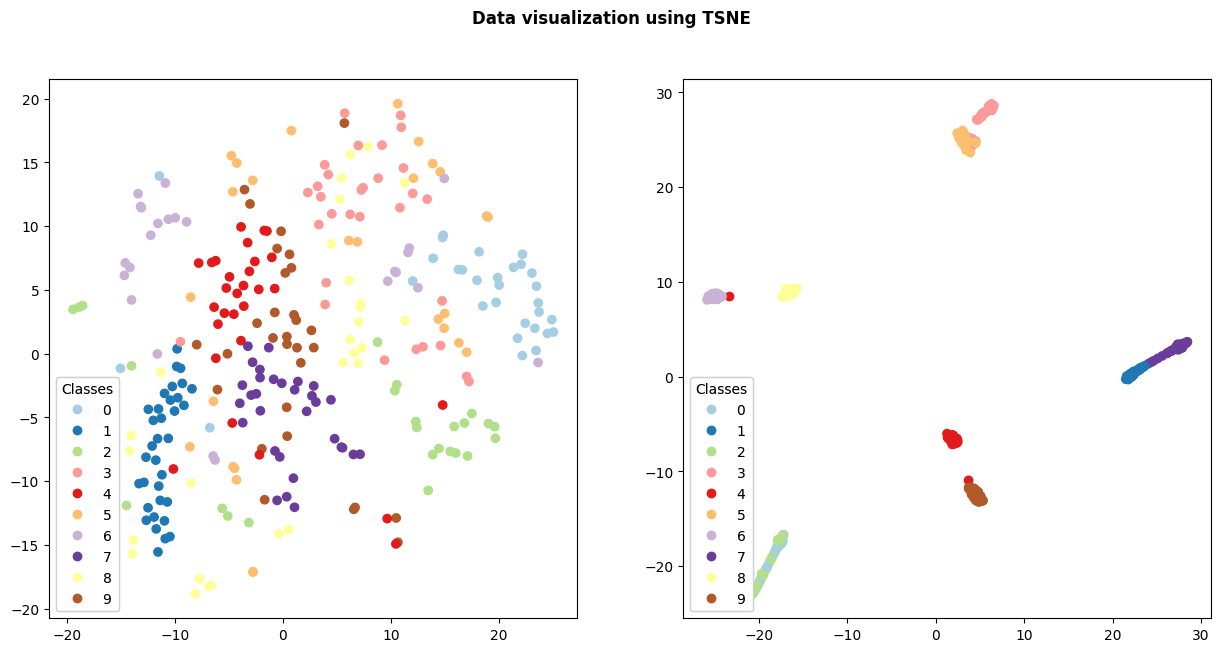

In [ ]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)
vis_x_embed = reduction_model_embedding.fit_transform(embedding_data)
#vis_x_embed = embedding_data

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
fig.suptitle("Data visualization using TSNE", weight="bold")
sc0 = ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Paired')
sc1 = ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=t.target, cmap="Paired")

legend1 = ax[1].legend(*sc1.legend_elements(),
                    loc="lower left", title="Classes")
ax[1].add_artist(legend1)

legend2 = ax[0].legend(*sc0.legend_elements(),
                    loc="lower left", title="Classes")
ax[0].add_artist(legend2)



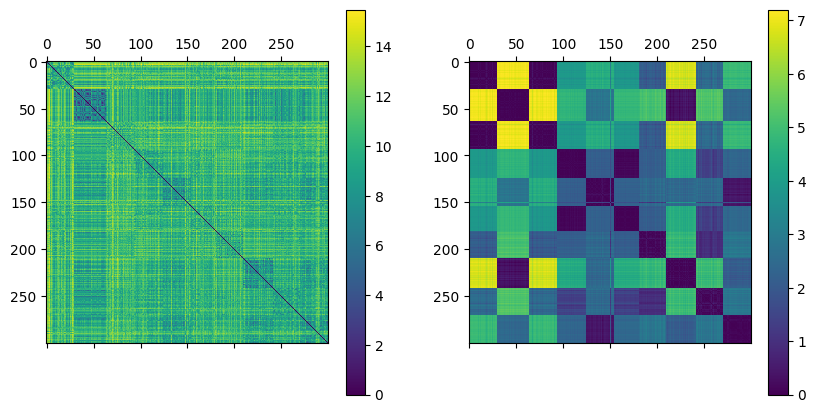

In [ ]:
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

order = t.target.argsort()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
c = axs[0].matshow(baseline_distance[order, :][:, order])
c2 = axs[1].matshow(learned_distance[order, :][:, order])
fig.colorbar(c)
fig.colorbar(c2)


In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.773
Purity:        0.707


In [ ]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.791
Purity:        0.793


In [ ]:

training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    clustering_data = np.empty((0,2))
    for anchor, _,_ in tqdm(training_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data,x.to("cpu").squeeze(0).numpy()), axis=0)

clustering_data

  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: 'TripletQuantumEmbedNet' object has no attribute 'conv_1'

In [ ]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

quantum_w = distance_model.q1.weight.detach().to("cpu").numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

def quantum_embedding_distance(x,y):

    base = QuantumRegister(8, "data")
    ancilla = QuantumRegister(1, 'ancilla')
    classical = ClassicalRegister(1, 'output')
    swap_circuit = QuantumCircuit(base, ancilla, classical)

    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    swap_circuit = swap_circuit.compose(q1, [0,1,2,3])
    swap_circuit = swap_circuit.compose(q2, [4,5,6,7])

    swap_circuit.barrier()

    swap_circuit.h(ancilla)
    swap_circuit.cswap(ancilla, 0,4)
    swap_circuit.cswap(ancilla, 1,5)
    swap_circuit.cswap(ancilla, 2,6)
    swap_circuit.cswap(ancilla, 3,7)
    swap_circuit.h(ancilla)
    swap_circuit.measure(ancilla,classical)

    backend = BasicProvider().get_backend('basic_simulator')
    qc = transpile(swap_circuit, backend)
    result = backend.run(qc, shots=1000).result().get_counts(qc).get('1',0)

    ret = result
    return ret


quantum_embedding_distance(clustering_data[16], clustering_data[8])

In [ ]:
from sklearn.metrics import pairwise_distances
val = 1000

angles_matrix = np.zeros((val, val))

cd = clustering_data[:val]

for i in tqdm(range(val)):
    for j in range(i):
        angles_matrix[i,j] = quantum_embedding_distance(cd[i], cd[j])
        angles_matrix[j,i] = angles_matrix[i,j]




In [ ]:
order = t.target[:val].argsort()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
c = axs[0].matshow(metrics.pairwise_distances(embedding_data[:val])[order, :][:, order])
c2 = axs[1].matshow(angles_matrix[order, :][:, order])
fig.colorbar(c)
fig.colorbar(c2)

In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(angles_matrix)
evaluate_clustering(embedding_data[:val], quantum_prediction, t.target[:val])

### Test evaluation

In [ ]:
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)

In [ ]:
embedder = distance_model.embedding

cembed = distance_model.embedding
qembed = distance_model.qembed

with torch.no_grad():
    cembed.eval()
    qembed.eval()
    test_embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(t_test_loader):
        anchor = anchor.to(device)
        test_embedding_data = np.concatenate((test_embedding_data, qembed(cembed(anchor)).to("cpu").squeeze(0).numpy()), axis=0)


100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


In [ ]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=129)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=129)

vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)
#vis_x_embed = test_embedding_data

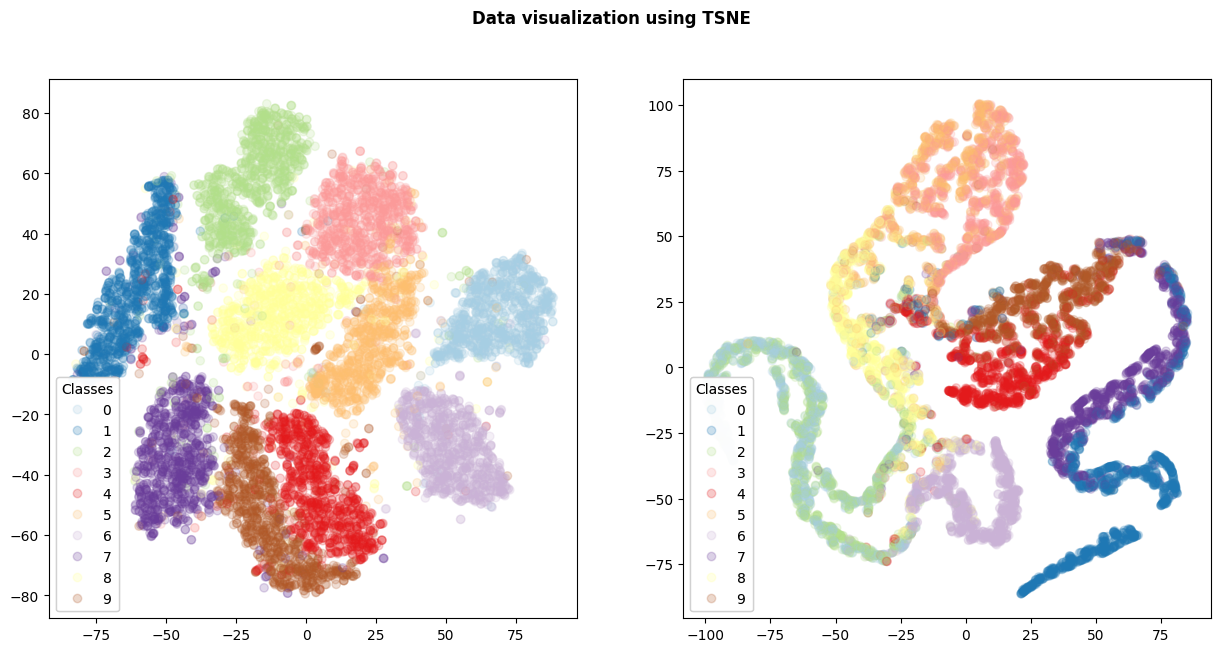

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
fig.suptitle("Data visualization using TSNE", weight="bold")
sc0 = ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target, cmap='Paired', alpha=0.2)
sc1 = ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=t_test.target, cmap="Paired",  alpha=0.2)

legend1 = ax[1].legend(*sc1.legend_elements(),
                    loc="lower left", title="Classes")
ax[1].add_artist(legend1)

legend2 = ax[0].legend(*sc0.legend_elements(),
                    loc="lower left", title="Classes")
ax[0].add_artist(legend2)

NameError: name 'quantum_prediction1' is not defined

<Figure size 4500x2100 with 0 Axes>

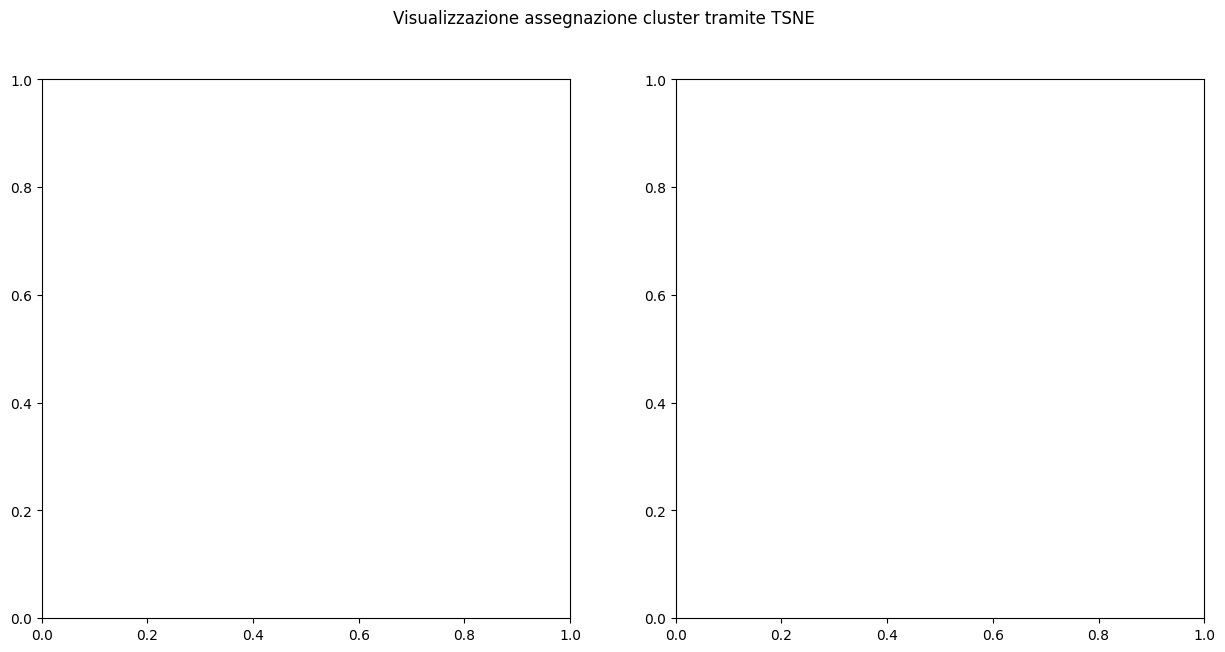

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(15, 7), dpi=300)

vals = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"}


labels = [vals[i] for i in t_test.target]



fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)

fig.suptitle("Visualizzazione assegnazione cluster tramite TSNE")

for i in range(10):
    ix = np.where(quantum_prediction1 == i)
    ax[0].scatter(vis_x_embed[ix,0], vis_x_embed[ix,1],label=str(i), cmap='Paired')

    ix = np.where(quantum_prediction2 == i)
    ax[1].scatter(vis_x_embed[ix,0], vis_x_embed[ix,1], label=str(i) , cmap="Paired")
    


ax[0].set_title("QuantumTripletLoss + Agglomeartive (Euclidean)")
ax[1].set_title("QuantumTripletLoss + KMeans")

ax[1].legend(loc="lower right", title="Classes")
ax[0].legend(loc="lower right", title="Classes")

In [ ]:
print("QUANTUM")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)

print("")

print("TSNE")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(vis_x)
evaluate_clustering(vis_x, quantum_prediction1, t_test.target)

QUANTUM
Silhouette:    0.625
Purity:        0.551

TSNE
Silhouette:    0.453
Purity:        0.817


In [ ]:

print("QUANTUM")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)

print("")


print("TSNE")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(vis_x)
evaluate_clustering(vis_x, quantum_prediction2, t_test.target)



QUANTUM
Silhouette:    0.629
Purity:        0.562

TSNE
Silhouette:    0.465
Purity:        0.823


In [ ]:
x = vis_x_embed[:,0]
y = vis_x_embed[:,1]
value = quantum_prediction1

xx,yy = np.meshgrid(x,y)
xx = xx.reshape(100*100)
yy = yy.reshape(100*100)
j = np.dstack((xx,yy,value))[0,:,:]

fig = plt.figure(figsize =(12,4))
ax1 = plt.subplot(121)
xi,yi = np.meshgrid(x,y)
va    = value.reshape(100,100)
pc = plt.pcolormesh(xi,yi,va,cmap = plt.cm.Spectral)
plt.colorbar(pc)

ax2 = plt.subplot(122)
y_pred = KMeans(n_clusters=12, random_state=43).fit_predict(j)
vb = y_pred.reshape(100,100)
plt.pcolormesh(xi,yi,vb,cmap = plt.cm.Accent)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

n_clusters = 10
fig, ax1,  = plt.subplots(1, 1)
fig.set_size_inches(7, 8)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
X = test_embedding_data
clusterer = AgglomerativeClustering(n_clusters=10, linkage="average")
cluster_labels = clusterer.fit_predict(test_embedding_data)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.terrain(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Curva Silhouette QuantumTripletLoss + Agglomerative (Euclidean) su FashionMNIST")
ax1.set_xlabel("Valori Silhouette per campione")
ax1.set_ylabel("Clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from matplotlib.pyplot import figure

def rgb_hex(color):
    '''converts a (r,g,b) color (either 0-1 or 0-255) to its hex representation.
    for ambiguous pure combinations of 0s and 1s e,g, (0,0,1), (1/1/1) is assumed.'''
    message='color must be an iterable of length 3.'
    assert hasattr(color, '__iter__'), message
    assert len(color)==3, message
    if all([(c<=1)&(c>=0) for c in color]): color=[int(round(c*255)) for c in color] # in case provided rgb is 0-1
    color=tuple(color)
    return '#%02x%02x%02x' % color

def get_cluster_colors(n_clusters, my_set_of_20_rgb_colors, alpha=0.8, alpha_outliers=0.05):
    cluster_colors = my_set_of_20_rgb_colors
    cluster_colors = [c+[alpha] for c in cluster_colors]
    outlier_color = [0,0,0,alpha_outliers]
    return [cluster_colors[i%19] for i in range(n_clusters)] + [outlier_color]

def cluster_and_plot_dendrogram():

    model = AgglomerativeClustering(n_clusters=10, linkage="average",  compute_distances=True)
    labels = model.fit_predict(test_embedding_data)

    #model = AgglomerativeClustering(n_clusters=10, linkage="average", metric="euclidean", compute_distances=True)
    #labels = model.fit_predict(t_test.get_flatten())

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    predefined_colors = [
       [46, 139, 87],   [70, 130, 180],  [75, 0, 130],   [0, 139, 139],
        [245, 130, 48], [255, 69, 0], [255, 215, 0], [0, 0, 128],
         [128, 128, 128], [250, 190, 190], [0, 128, 128], [230, 190, 255],
        [170, 110, 40], [255, 250, 200], [128, 0, 0], [170, 255, 195],
        [128, 128, 0], [255, 215, 180], [0, 0, 128], [128, 128, 128]
    ]


    # perform hierarchical clustering
    Z              = linkage_matrix

    # get cluster labels
    labels_str     = [f"cluster #{l}: n={c}\n" for (l,c) in zip(*np.unique(labels, return_counts=True))]
    n_clusters     = len(labels_str)

    cluster_colors = [rgb_hex(c[:-1]) for c in get_cluster_colors(n_clusters, predefined_colors, alpha=0.8, alpha_outliers=0.05)]
    cluster_colors_array = [cluster_colors[l] for l in labels]
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else cluster_colors_array[x] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'k'

    # plot dendrogram with colored clusters
    fig = plt.figure(figsize=(10, 4), dpi=300)
    plt.title('Dendrogramma modello QuantumTripletLoss + Agglomerative (Euclidean) su FashionMNIST')
    plt.xlabel('Campioni')
    plt.ylabel('Distanza')

    t = 0

    # plot dendrogram based on clustering results
    dendrogram(
        Z,

        labels = labels,

        color_threshold=0,

        truncate_mode = 'level',
        p = 5,
        show_leaf_counts = True,
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=False,
        link_color_func=lambda x: link_cols[x],
        distance_sort='descending',
        ax=plt.gca(),
        above_threshold_color="C0"
    )
    #plt.axhline(100, color='k')
    for i, s in enumerate(labels_str):
        plt.text(0.8, 0.95-i*0.04, s,
                transform=plt.gca().transAxes,
                va='top', color=cluster_colors[i])
    
    fig.patch.set_facecolor('white')
    return labels # 0 indexed

cluster_and_plot_dendrogram()


In [ ]:
test_dataloader = DataLoader(t_test, batch_size=10, shuffle=False)

clustering_data = np.empty((0,8))
with torch.no_grad():
    for anchor, _,_ in tqdm(test_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data, x.to("cpu").squeeze(0).numpy()), axis=0)

X_train, _, y_train, _ = train_test_split(clustering_data, y_test, train_size=1000, stratify=y_test)

In [ ]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

quantum_w = distance_model.q1.weight.detach().to("cpu").numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

base = QuantumRegister(8, "data")
ancilla = QuantumRegister(1, 'ancilla')
classical = ClassicalRegister(1, 'output')
swap_circuit = QuantumCircuit(base, ancilla, classical)

swap_register = QuantumCircuit(9,1)
swap_register.h(8)
swap_register.cswap(8, 0,4)
swap_register.cswap(8, 1,5)
swap_register.cswap(8, 2,6)
swap_register.cswap(8, 3,7)
swap_register.h(8)
swap_register.measure(8,0)



backend = BasicProvider().get_backend('basic_simulator')

In [ ]:
def quantum_embedding_distance(x,y):

    swap_model = swap_circuit.copy()
    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    swap_model = swap_model.compose(q1, [0,1,2,3])
    swap_model = swap_model.compose(q2, [4,5,6,7])

    swap_model.barrier()

    swap_model = swap_model.compose(swap_register)

    qc = transpile(swap_model, backend)
    result = backend.run(qc, shots=5000).result().get_counts(qc).get('1',0) 

    ret = result
    return ret

%timeit quantum_embedding_distance(X_train[1], X_train[5])

In [ ]:
from sklearn.metrics import pairwise_distances

swap_matrix = pairwise_distances(X_train, metric=quantum_embedding_distance)

In [ ]:
with open("SWAP_matix_FMNIST.data", "wb") as f:
    pickle.dump(swap_matrix, f)

In [ ]:
baseline_distance = metrics.pairwise_distances(t_test.get_flatten())
learned_distance = metrics.pairwise_distances(test_embedding_data)

#order = y_test.argsort()

mat = [
    [5,26,5],[48,3,6], [0,6,25]]


fig, axs = plt.subplots()
fig.set_size_inches(18, 7)

#c = axs.matshow(baseline_distance[order, :][:, order])
c = axs.matshow(mat, cmap="Greens")

for (i, j), z in np.ndenumerate(mat):
    axs.text(j, i, '{:d}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
#c = axs.matshow(swap_matrix[order, :][:, order], cmap="Accent")
axs.set_xticks([])
axs.set_yticks([])
fig.colorbar(c)


In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="complete", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(swap_matrix)
evaluate_clustering(X_train, quantum_prediction, y_train)

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk

quantum_clustering = KMeansClusterer(num_means=10, distance=quantum_embedding_distance)

In [ ]:

quantum_prediction = quantum_clustering.cluster(clustering_data, assign_clusters=True)
evaluate_clustering(clustering_data, quantum_prediction, y_test)

In [ ]:
model = AgglomerativeClustering(n_clusters=10, metric=quantum_embedding_distance, linkage="average")
pred = model.fit_predict(clustering_data)

In [ ]:
baseline_distance = metrics.pairwise_distances(t_test.get_flatten())
learned_distance = metrics.pairwise_distances(test_embedding_data)

order = t_test.target.argsort()

fig, axs = plt.subplots()
fig.set_size_inches(18, 7)

c = axs.matshow(baseline_distance[order, :][:, order])
#c = axs.matshow(learned_distance[order, :][:, order])
#c = axs.matshow(angles_matrix[order, :][:, order])
axs.set_xticks([])
axs.set_yticks([])
fig.colorbar(c)
